In [85]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import datetime
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## Data Read and Cleanup

In [86]:
# Load the data from .sqlite file

db=sqlite3.connect('../input/database.sqlite')

# select all reviews from given dataset
# we are considering a review is positive or negative on the basis of the Score column which is nothing but a rating given
# by a customer for a product. If a score >3 it is considered as positive elseif score<3 it is negative and score=3 is neutral
# Therefore all reviews which are having score other than 3 are taken into account.

filtered_data=pd.read_sql_query("""
SELECT *
FROM Reviews WHERE Score!=3""",db)

# Replace this numbers in Score column as per our assumptions i.e replace 3+ with positive 1 and 3- with negative 0
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be positive (1) and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)


(525814, 10)


In [87]:
# converting datestamp into string representable form as YYYY-MM-DD
filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d'))

In [88]:
# There is lot of duplicate data present as we can see above productId B007OSBE1U 
# have multiple duplicate reviews this is what we need to avoid.

# so first step is to sort the data and then remove duplicate entries so that only
# one copy of them should be remain in our data.
dup_free=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})
# dup_free.head()
# This is shape of our dataset of 100k datapoints after removal of dups
dup_free.shape

(364173, 10)

In [89]:
final_filtered_data=dup_free[dup_free.HelpfulnessNumerator<=dup_free.HelpfulnessDenominator]

In [90]:
final_filtered_data.shape

(364171, 10)

In [91]:
((final_filtered_data['Id'].size*1.0)/(filtered_data['Id'].size*(1.0)))*100

69.25852107399194

#### so after data cleanup we left with 69.25% data of 525k datapoints

In [92]:
# reference:https://www.geeksforgeeks.org/python-pandas-dataframe-sample/
#As randomly select data, in order that our dataset remain balanced
positive_rev = final_filtered_data[final_filtered_data.Score ==1]
positive_rev = positive_rev.sample(frac=0.20,random_state=1)
print("Positive Reviews: ",len(positive_rev))

negative_rev = final_filtered_data[final_filtered_data.Score == 0]
negative_rev = negative_rev.sample(frac=0.85,random_state=1)
print("Negative Reviews: ",len(negative_rev))

final = pd.concat([positive_rev,negative_rev],axis=0)
#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final=final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

Positive Reviews:  61412
Negative Reviews:  48544


In [93]:
print("Proportion of positive reviews :",len(positive_rev)/len(final))
print("Proportion of negative reviews :",len(negative_rev)/len(final))

Proportion of positive reviews : 0.5585143148168358
Proportion of negative reviews : 0.44148568518316417


### Dataset seems balanced now with 55% positive reviews and 44% negative reviews

## Text Preprocessing 

In [94]:
# Now we have already done with data cleanup part. As in our dataset most cruicial or I can say most determinant feature
# from which we can say it is positive or negative review is review Text.
# So we are need to perform some Text Preprocessing on it before we actually convert it into word vector or vectorization

# I am creating some precompiled objects for our regular expressions cause it will be used for over ~64K times (in our case)
# as it seems fast but using regular expression is CPU expensive task so it would be faster to use precompiled search objects.

_wont  = re.compile(r"won't")
_cant  = re.compile(r"can\'t")
_not   = re.compile(r"n\'t")
_are   = re.compile(r"\'re")
_is    = re.compile(r"\'s")
_would = re.compile(r"\'d")
_will  = re.compile(r"\'ll")
_have  = re.compile(r"\'ve")
_am    = re.compile(r"\'m")

# we are ignoring "not" from stopwords as "not" plays important role for semantic analysis as it can alone change the 
# meaning of whole sentence
stopWords = set(stopwords.words('english'))
sw=stopWords.copy()
sw.discard('not')

def expand_abbrevated_words(phrase):
    phrase = re.sub(_wont, "will not", phrase)
    phrase = re.sub(_cant, "can not", phrase)
    phrase = re.sub(_not, " not", phrase)
    phrase = re.sub(_are, " are", phrase)
    phrase = re.sub(_is, " is", phrase)
    phrase = re.sub(_would, " would", phrase)
    phrase = re.sub(_will, " will", phrase)
    phrase = re.sub(_have, " have", phrase)
    phrase = re.sub(_am, " am", phrase)
    return phrase

# As this dataset is web scrapped from amazon.com while scrapping there might be a good chance that we are getting some garbage
# characters/words/sentences in our Text data like html tags,links, alphanumeric characters so we ought to remove them
def remove_unwanted_char(data):    
    processed_data=[]
    for sentence in tqdm(data):
        sentence = re.sub(r"http\S+", "", sentence) # this will remove links
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = re.sub("\S*\d\S*", "", sentence).strip() #remove alphanumeric words
        sentence = re.sub('[^A-Za-z]+', ' ', sentence) #remove special characters
        sentence =  expand_abbrevated_words(sentence)
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in sw)
        processed_data.append(sentence.strip())
    return processed_data

# In this first thing is we need to convert everything into lower case because I dont want my model to treat same word differently
# if it appears in the begining of sentence and somewhere middle of sentence.
# Also remove stopword froms from sentences 
def preprocess_my_data(data):    
    return remove_unwanted_char(data)
        

In [95]:
data_to_be_processed=final['Text'].values
processed_data=preprocess_my_data(data_to_be_processed)
label=final['Score']
print(len(processed_data))

100%|██████████| 109956/109956 [00:54<00:00, 2016.45it/s]

109956


In [96]:
final['CleanedText']=processed_data
print(processed_data[0])

twist rumplestiskin captured film starring michael keaton geena davis prime tim burton masterpiece rumbles absurdity wonderfully paced point not dull moment


## Stemming

In [97]:
# Before applying BoW or Tfidf featurization techinque on our corpus we need to apply stemmming for each word in each document.
stemmed_data=processed_data.copy()
bow_stem=SnowballStemmer('english',ignore_stopwords=True)
stemmed_reviews=[]
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(bow_stem.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

for sentence in tqdm(stemmed_data):
    stemmed_reviews.append(stemSentence(sentence))

100%|██████████| 109956/109956 [01:48<00:00, 1013.56it/s]


## Splitting Data In Train ,CV and Test Dataset

In [98]:
# To avoid data leakage we are splitting our dataset before any featurization.
x_tr, x_test, y_tr, y_test = train_test_split(stemmed_reviews, label, test_size=0.3, random_state=0)

print("Sizes of Train,test dataset after split: {0} , {1}".format(len(x_tr),len(x_test)))

Sizes of Train,test dataset after split: 76969 , 32987


## HyperParameter Tuning Using k-fold Cross-Validation

##### Before training our model with Multinomial NB classifier we are setting our class priors to 0.5 defaults so as to miminise the effect of imbalnced nature of dataset i.e Upsampling

In [99]:
def find_best_alpha(train_data,tr_label):
    alpha_li = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000]
    nb = MultinomialNB()
    parameters = [{'alpha':alpha_li,'class_prior': [[0.5, 0.5]]}]

    tbs_cv = TimeSeriesSplit(n_splits=5).split(train_data)
    gsearch = GridSearchCV(estimator=nb, cv=tbs_cv,
                        param_grid=parameters, scoring = 'roc_auc')
    gsearch.fit(train_data, tr_label)
    
    print("Best alpha   : ",gsearch.best_estimator_.alpha)
    print("Best AUC     : ",gsearch.score(train_data, tr_label))
    
    test_auc=gsearch.cv_results_['mean_test_score']
    train_auc=gsearch.cv_results_['mean_train_score']
    
    alpha_li=np.log(alpha_li)
    plt.plot(alpha_li, test_auc,'bo',linestyle="solid",label='Test AUC')
    plt.plot(alpha_li, train_auc,'yo',linestyle="solid",label='Train AUC')
    plt.xlabel('log(alpha) values')
    plt.ylabel('AUC')
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
    return gsearch.best_estimator_.alpha

In [100]:
def testing_on_test_data(train_rev,train_label,test_rev,test_label,best_alpha):
    plt.figure(1)
    m_NB=MultinomialNB(alpha=best_alpha,class_prior = [0.5, 0.5])
    m_NB.fit(train_rev,train_label)
    train_pred = m_NB.predict_log_proba(train_rev)[:,1]
    test_pred= m_NB.predict_log_proba(test_rev)[:,1]
    # Train data AUC value
    fpr_tr,tpr_tr, _  = roc_curve(train_label, train_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    
    # Test data AUC value
    fpr_t,tpr_t, _  = roc_curve(test_label, test_pred)
    roc_auc_t= auc(fpr_t, tpr_t)
    
    plt.plot(fpr_tr, tpr_tr, color='darkorange',
             lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_tr)
    plt.plot(fpr_t, tpr_t, color='black',
             lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_t)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Train and Test dataset')
    plt.legend(loc="lower right")

    plt.show()

In [101]:
def get_confusion_matrix(train_rev,train_label,test_rev,test_label,best_alpha):
    plt.figure(1,figsize=(15,7))
    np.set_printoptions(precision=5)
    
    m_NB=MultinomialNB(alpha=best_alpha,class_prior = [0.5, 0.5])
    m_NB.fit(train_rev,train_label)
    train_pred=m_NB.predict(train_rev)
    test_pred=m_NB.predict(test_rev)
    test_cnf_matrix=confusion_matrix(test_label,test_pred)
    train_cnf_matrix=confusion_matrix(train_label,train_pred)
    
    plt.subplot(121)
    sns.heatmap(test_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TestSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    
    plt.subplot(122)
    sns.heatmap(train_cnf_matrix,cmap="coolwarm_r",fmt='.8g',annot=True,linewidths=0.5)
    plt.title("TrainSet Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Actual class")
    plt.show()

In [102]:
def get_top_imp_features(train_rev,labels,best_alpha,vectorizer):
    m_NB=MultinomialNB(alpha=best_alpha,class_prior = [0.5, 0.5])
    m_NB.fit(train_rev,labels)
    #this sorts the  features probabilities return index of sorted values
    class_prob_pos=m_NB.feature_log_prob_[1].argsort()
    # As we are sorting in ascending order, last 10 likelihoods will be of positive class 
    # and first 10 will be of negative class
    # feature_log_prob_ stores 
    positive_class_prob=np.take(vectorizer.get_feature_names(), class_prob_pos[-10:])
    negative_class_prob=np.take(vectorizer.get_feature_names(), class_prob_pos[:10])
    print("Top Ten Positive Features: ",positive_class_prob)
    print("Top Ten Negative Features: ",negative_class_prob)

## Applying Multinomial Naive Bayes

## 1. BoW (Bag of Words)

In [103]:
# Applying fit_transform to only train dataset as we are only because we want our vocabulary to be built only on train data
bow_count=CountVectorizer(min_df=10, max_features=300)
bow_fit=bow_count.fit(x_tr)
print("Some Feature names: ",bow_fit.get_feature_names()[:5])

#extract token count out of raw text document using vocab build using train dataset
bow_train=bow_count.transform(x_tr)
bow_test=bow_count.transform(x_test)

print("Shape of transformed train text reviews",bow_train.shape)
print("Shape of transformed test text reviews",bow_test.shape)


Some Feature names:  ['abl', 'absolut', 'actual', 'ad', 'add']
Shape of transformed train text reviews (76969, 300)
Shape of transformed test text reviews (32987, 300)


In [104]:
# converting sparse matrix to dense matrix before doing standardization 
bow_dense_tr_rev=bow_train.toarray()
bow_dense_tst_rev=bow_test.toarray()

## Finding Best alpha

Best alpha   :  10
Best AUC     :  0.8792122241928693


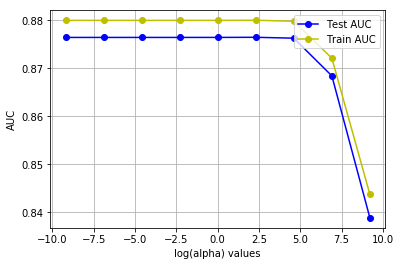

In [105]:
best_alpha=find_best_alpha(bow_dense_tr_rev,y_tr)

## Feature importance

### Top 10 important features of positive and negative class

In [106]:
get_top_imp_features(bow_dense_tr_rev,y_tr,best_alpha=best_alpha,vectorizer=bow_fit)

Top Ten Positive Features:  ['product' 'one' 'use' 'great' 'love' 'flavor' 'good' 'tast' 'like' 'not']
Top Ten Negative Features:  ['return' 'wast' 'label' 'date' 'pay' 'mayb' 'money' 'stick' 'took' 'list']


### Applying unseen data to our Model

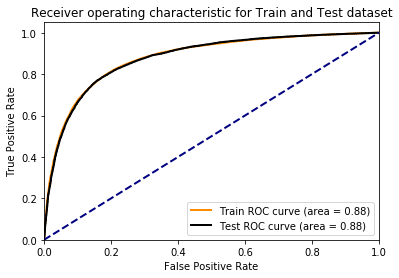

In [107]:
testing_on_test_data(bow_dense_tr_rev,y_tr,bow_dense_tst_rev,y_test,best_alpha=best_alpha)

### Confusion Matrix

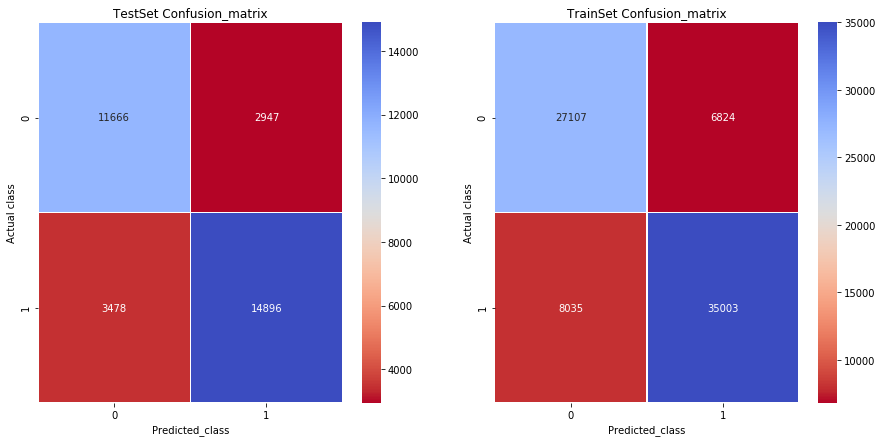

In [108]:
get_confusion_matrix(bow_dense_tr_rev,y_tr,bow_dense_tst_rev,y_test,best_alpha=best_alpha)

## 2. TFIDF 

In [109]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=300)
tfidf_tr=tfidf_count.fit_transform(x_tr)
tfidf_test=tfidf_count.transform(x_test)
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)


Shape of tfidf vector representation of train review text : (76969, 300)
Shape of tfidf vector representation of test review text  : (32987, 300)


In [110]:
# converting sparse matrix to dense matrix before doing standardization 
tfidf_dense_train_reviews=tfidf_tr.toarray()
tfidf_dense_test_reviews=tfidf_test.toarray()


## Finding Best alpha

Best alpha   :  100
Best AUC     :  0.8875925936129153


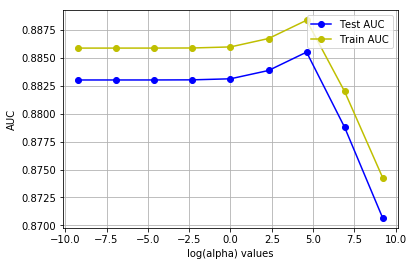

In [111]:
best_alpha=find_best_alpha(tfidf_dense_train_reviews,y_tr)

## Feature importance

### Top 10 important features of positive and negative class

In [112]:
get_top_imp_features(tfidf_dense_train_reviews,y_tr,best_alpha=best_alpha,vectorizer=tfidf_count)

Top Ten Positive Features:  ['coffe' 'tea' 'use' 'not' 'flavor' 'like' 'tast' 'good' 'love' 'great']
Top Ten Negative Features:  ['return' 'wast' 'label' 'date' 'mayb' 'list' 'disappoint' 'money' 'pay'
 'took']


### Applying unseen data to our Model

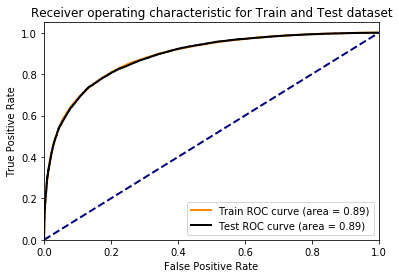

In [113]:
testing_on_test_data(tfidf_dense_train_reviews,y_tr,tfidf_dense_test_reviews,y_test,best_alpha=best_alpha)

### Confusion Matrix

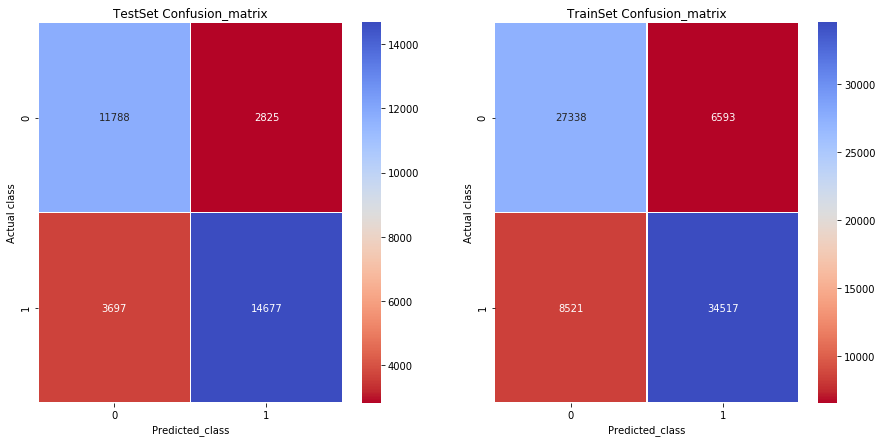

In [114]:
get_confusion_matrix(tfidf_dense_train_reviews,y_tr,tfidf_dense_test_reviews,y_test,best_alpha=best_alpha)

## 3. TFIDF (2 gram)

In [115]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=300,ngram_range=(2,2))
tfidf_tr=tfidf_count.fit_transform(x_tr)
tfidf_test=tfidf_count.transform(x_test)
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)

Shape of tfidf vector representation of train review text : (76969, 300)
Shape of tfidf vector representation of test review text  : (32987, 300)


In [116]:
# converting sparse matrix to dense matrix before doing standardization 
tfidf_dense_train_reviews=tfidf_tr.toarray()
tfidf_dense_test_reviews=tfidf_test.toarray()


## Finding Best alpha

Best alpha   :  0.0001
Best AUC     :  0.7986541109486442


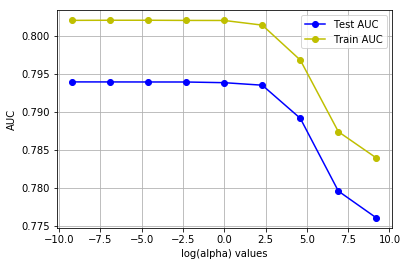

In [117]:
best_alpha=find_best_alpha(tfidf_dense_train_reviews,y_tr)

## Feature importance

### Top 10 important features of positive and negative class

In [118]:
get_top_imp_features(tfidf_dense_train_reviews,y_tr,best_alpha=best_alpha,vectorizer=tfidf_count)

Top Ten Positive Features:  ['realli like' 'great tast' 'dog love' 'great product' 'tast good'
 'gluten free' 'groceri store' 'tast like' 'tast great' 'high recommend']
Top Ten Negative Features:  ['bad batch' 'not worth' 'wast money' 'not order' 'never buy'
 'not purchas' 'bad tast' 'not work' 'made china' 'throw away']


### Applying unseen data to our Model

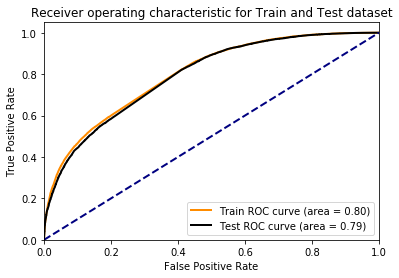

In [119]:
testing_on_test_data(tfidf_dense_train_reviews,y_tr,tfidf_dense_test_reviews,y_test,best_alpha=best_alpha)

### Confusion Matrix

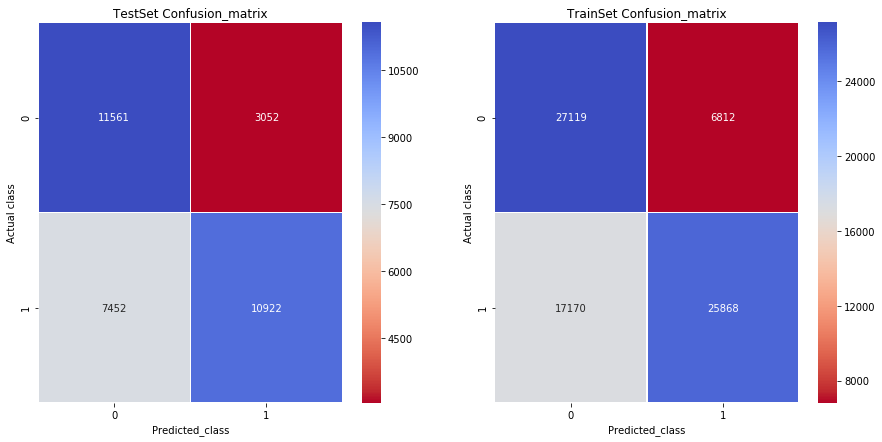

In [120]:
get_confusion_matrix(tfidf_dense_train_reviews,y_tr,tfidf_dense_test_reviews,y_test,best_alpha=best_alpha)

# Feature Engineering

In [121]:
# Adding review text length as feature to check if model performance increases further.
feature_eng=[]
for x in tqdm(stemmed_reviews):
    x_split=x.split()
    feature_eng.append(len(x_split))

100%|██████████| 109956/109956 [00:00<00:00, 327378.26it/s]


In [122]:
df={'Reviews':stemmed_reviews,'Review_Length':feature_eng}

In [123]:
new_data=pd.DataFrame(df)
new_data.head()

,Reviews,Review_Length
0,twist rumplestiskin captur film star michael k...,21
1,one movi movi collect fill comedi action whate...,11
2,alway enjoy movi funni entertain hesit pick cl...,31
3,get crazi realli imposs today not find french ...,17
4,recent purchas woodstream corp gopher trap wit...,44


## Split Data into Train and Test set

In [124]:
# To avoid data leakage we are splitting our dataset before any featurization.
x_tr, x_test, y_tr, y_test = train_test_split(new_data, label, test_size=0.3, random_state=0)

print("Sizes of Train,test dataset after split: {0} , {1}".format(len(x_tr),len(x_test)))

Sizes of Train,test dataset after split: 76969 , 32987


## Apply BoW

In [125]:
# Applying fit_transform to only train dataset as we are only because we want our vocabulary to be built only on train data
bow_count=CountVectorizer(min_df=10, max_features=300)
bow_fit=bow_count.fit(x_tr['Reviews'])
print("Some Feature names: ",bow_fit.get_feature_names()[:5])

#extract token count out of raw text document using vocab build using train dataset
bow_train=bow_count.transform(x_tr['Reviews'])
bow_test=bow_count.transform(x_test['Reviews'])

print("Shape of transformed train text reviews",bow_train.shape)
print("Shape of transformed test text reviews",bow_test.shape)


Some Feature names:  ['abl', 'absolut', 'actual', 'ad', 'add']
Shape of transformed train text reviews (76969, 300)
Shape of transformed test text reviews (32987, 300)


In [126]:
bow_train_dense=bow_train.toarray()
bow_test_dense=bow_test.toarray()

## Adding Review_Length feature

#### 1. Train Data

In [127]:
train_rev_df=pd.DataFrame(bow_train_dense.tolist())
tr_rev_len=pd.DataFrame(x_tr['Review_Length'],columns=['Review_Length'])
# Setting same indexes as NaN values are getting added in Review_Length column due to different indexes for dataframes
train_rev_df=train_rev_df.set_index(tr_rev_len.index)

In [128]:
train_rev_df['Review_Length']=tr_rev_len['Review_Length']
train_rev_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Review_Length
14957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,37
71682,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,127
22869,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,56
80023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,24
37871,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,72


#### 2. Test Data

In [129]:
test_rev_df=pd.DataFrame(bow_test_dense.tolist())
test_rev_len=pd.DataFrame(x_test['Review_Length'],columns=['Review_Length'])
# Setting same indexes as NaN values are getting added in Review_Length column due to different indexes for dataframes
test_rev_df=test_rev_df.set_index(test_rev_len.index)

In [130]:
test_rev_df['Review_Length']=test_rev_len['Review_Length']
test_rev_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Review_Length
46101,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22
64267,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
42079,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,16
89718,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,19
59112,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53


### Find Best alpha

Best alpha   :  10
Best AUC     :  0.8795158701594588


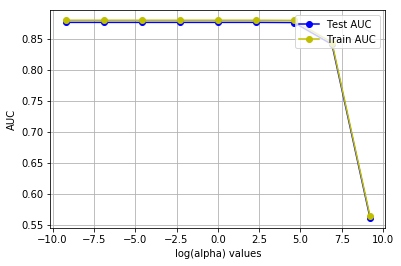

In [131]:
best_alpha=find_best_alpha(train_rev_df,y_tr)

In [132]:
def get_top_feat(rev,labels,vectorizer,alpha):
    m_NB=MultinomialNB(alpha=0.0001,class_prior = [0.5, 0.5])
    m_NB.fit(rev,labels)
    #this sorts the  features probabilities return index of sorted values
    class_prob_pos=m_NB.feature_log_prob_[1].argsort()
    pos_index=class_prob_pos[-10:]
    neg_index=class_prob_pos[:10]
    pos_index=pos_index.tolist()
    neg_index=neg_index.tolist()
    
    
    feat=vectorizer.get_feature_names()
    top_pos=[feat[x-1] for x in pos_index]
    top_neg=[feat[x-1] for x in neg_index]
    print("Top Positive Features :",top_pos)
    print("Top Negative Features :",top_neg)

### Top 10 important features of positive and negative class

In [133]:
get_top_feat(train_rev_df,y_tr,bow_fit,best_alpha)

Top Positive Features : ['old', 'us', 'got', 'lot', 'first', 'go', 'take', 'light', 'nice', 'year']
Top Negative Features : ['regular', 'want', 'know', 'dark', 'pasta', 'may', 'mix', 'start', 'time', 'like']


### Applying unseen data to our Model

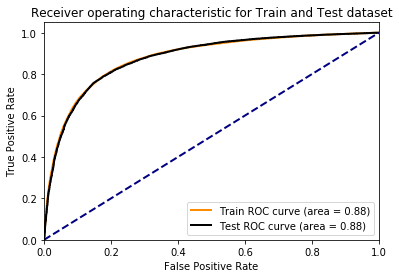

In [134]:
testing_on_test_data(train_rev_df,y_tr,test_rev_df,y_test,best_alpha=best_alpha)

### Confusion Matrix

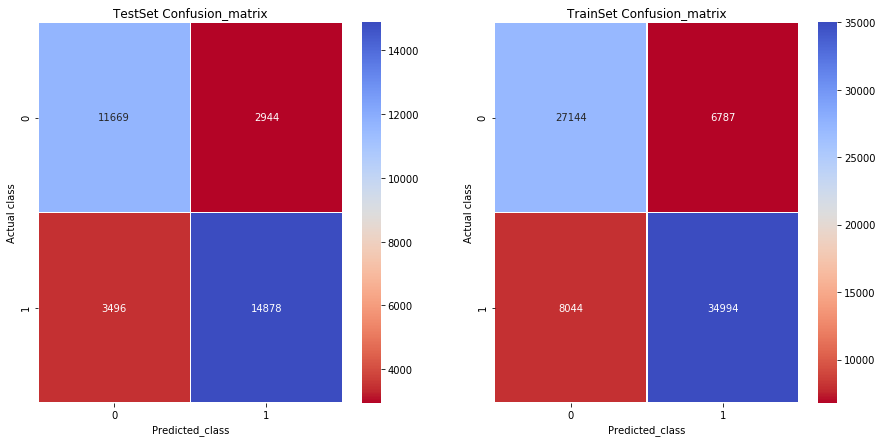

In [135]:
get_confusion_matrix(train_rev_df,y_tr,test_rev_df,y_test,best_alpha=best_alpha)

## 2. TFIDF (2-Gram)

In [136]:
tfidf_count= TfidfVectorizer(min_df=10,max_features=300,ngram_range=(2,2))
tfidf_tr=tfidf_count.fit_transform(x_tr['Reviews'])
tfidf_test=tfidf_count.transform(x_test['Reviews'])
print("Shape of tfidf vector representation of train review text :",tfidf_tr.shape)
print("Shape of tfidf vector representation of test review text  :",tfidf_test.shape)

Shape of tfidf vector representation of train review text : (76969, 300)
Shape of tfidf vector representation of test review text  : (32987, 300)


In [137]:
# converting sparse matrix to dense matrix before doing standardization 
tfidf_dense_train_reviews=tfidf_tr.toarray()
tfidf_dense_test_reviews=tfidf_test.toarray()

## Adding Review_Length feature

#### 1. Train

In [138]:
train_rev_df=pd.DataFrame(tfidf_dense_train_reviews.tolist())
tr_rev_len=pd.DataFrame(x_tr['Review_Length'],columns=['Review_Length'])
# Setting same indexes as NaN values are getting added in Review_Length column due to different indexes for dataframes
train_rev_df=train_rev_df.set_index(tr_rev_len.index)

In [139]:
train_rev_df['Review_Length']=tr_rev_len['Review_Length']
train_rev_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Review_Length
14957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
71682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127
22869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.340389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56
80023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
37871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72


#### 2. Test

In [140]:
test_rev_df=pd.DataFrame(tfidf_dense_test_reviews.tolist())
test_rev_len=pd.DataFrame(x_test['Review_Length'],columns=['Review_Length'])
# Setting same indexes as NaN values are getting added in Review_Length column due to different indexes for dataframes
test_rev_df=test_rev_df.set_index(test_rev_len.index)

In [141]:
test_rev_df['Review_Length']=test_rev_len['Review_Length']
test_rev_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Review_Length
46101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22
64267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
42079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
89718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
59112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.606101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.585187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53


### Find Best alpha

Best alpha   :  1
Best AUC     :  0.8002480761135059


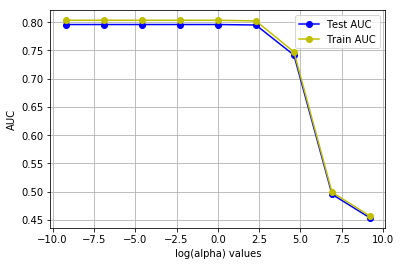

In [142]:
best_alpha=find_best_alpha(train_rev_df,y_tr)

### Top 10 important features of positive and negative class

In [143]:
get_top_feat(train_rev_df,y_tr,tfidf_count,best_alpha)

Top Positive Features : ['great product', 'dog food', 'great price', 'tast coffe', 'give tri', 'green tea', 'tast great', 'tast good', 'high qualiti', 'year old']
Top Negative Features : ['babi food', 'not work', 'want tri', 'not one', 'natur flavor', 'not order', 'bad batch', 'not want', 'mac chees', 'thought would']


### Applying unseen data to our Model

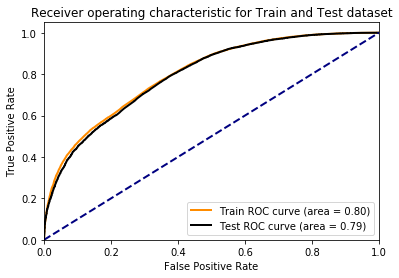

In [144]:
testing_on_test_data(train_rev_df,y_tr,test_rev_df,y_test,best_alpha=best_alpha)

### Confusion Matrix

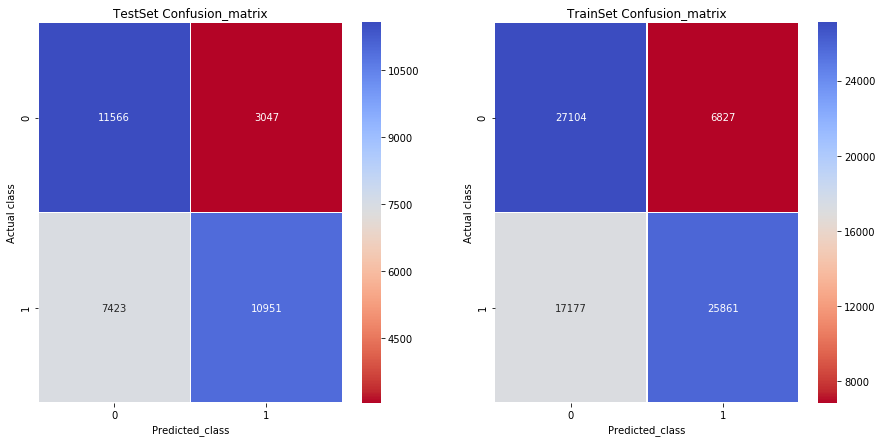

In [145]:
get_confusion_matrix(train_rev_df,y_tr,test_rev_df,y_test,best_alpha=best_alpha)

In [147]:
print("""
          |  Vectorizer    |   Model            |   HyperParameter  |    Test AUC    |
          __________________________________________________________________________

              BoW          |    Multinomial NB  |         100       |      0.88      |
             tfidf         |    Multinomial NB  |         100       |      0.89      |
             tfidf(2-gram) |    Multinomial NB  |         0.1       |      0.79      |
            
        After Adding Review_length as additional feature
          
          |  Bow           |    Multinomial NB  |         10        |      0.88      |
          |  tfidf(2-gram) |    Multinomial NB  |         100       |      0.79      |
             """)


          |  Vectorizer    |   Model            |   HyperParameter  |    Test AUC    |
          __________________________________________________________________________

              BoW          |    Multinomial NB  |         100       |      0.88      |
             tfidf         |    Multinomial NB  |         100       |      0.89      |
             tfidf(2-gram) |    Multinomial NB  |         0.1       |      0.79      |
            
        After Adding Review_length as additional feature
          
          |  Bow           |    Multinomial NB  |         10        |      0.88      |
          |  tfidf(2-gram) |    Multinomial NB  |         100       |      0.79      |
             


### Conclusion:

1. Naive Bayes is classification algorithm which is based on Bayes Theorem with "Naive" assumption of Conditional Independence, i.e all features are conditionally independent from each other given a class label.

2. There are 3 variant of Naive Bayes theorem namely-
   *  Gaussian Naive Bayes    - Used when we assume likelihood probablities follow Gaussian Distribution

   *  Bernoulli's Naive Bayes - Used when our likelihood follows Bernoulli's Distribution i.e features only take 2                                     values
   *  Multinomial Naive Bayes - Used when our likelihood takes multiple values.
   
    
3. We are using Multinomial Naive Bayes as it is suitable for text classification with discrete features like word counts.

4. alpha is Hyperparameter for Multinomial Naive Bayes classifier.

5. Before training our model with Multinomial NB classifier we are setting our class priors to 0.5 defaults so as to miminise the effect of imbalnced nature of dataset i.e Upsampling

6. When we apply BoW or tfidf vectorized data to train our model we can observed the top positive and negative words/features i.e words are not justifying the class which they belongs.

7. On the other hand when we apply 2-gram tfidf vectorized data to train our model, it is observed the top positive and negative words/features are more sensible

8. When we do some feature engineering by adding Review_Length as additional feature to train our model, it affect ou hyperparameter value a lot in case of TFIDF (2-gram) but AUC is observed to be same for both models trained with BoW vectorized reviews and TFIDF vectorized reviews.

9. As we are taking 62k positive and 48k negative reviews from our whole corpus our dataset is pretty balanced.So we are concerning about only AUC as performance metric

10. ROCAUC value for Random Classifier is 0.5 and our models getting values greter than 0.5 so we can say our models are good classifiers.